<a href="https://colab.research.google.com/github/sunyingjian/-Logging-related-network/blob/master/%E7%BE%8E%E5%9B%BD%E6%B2%B9%E7%94%B0GMM_smote_knn_gbdt%2C%E9%9A%8F%E6%9C%BA%E6%A3%AE%E6%9E%97%EF%BC%8Cxgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <font size=5px color="red">✦ *Google Colab 突破90分钟自动断开:</font>
<p><font size=3px > 每60分钟自动运行代码以刷新90分钟断开限制. 打开 developer-settings (在你的浏览器) 快速健 Ctrl+Shift+I 然后按console 输入以下代码 Enter. ( mac 按 Option+Command+I)</p><b>复制以下隐藏代码粉贴在浏览器console！！不要关闭浏览器以免失效</b>

<code>function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-connect-button").click() 
}setInterval(ClickConnect,6000)</code>

In [ ]:
#@markdown <h3>← 输入了代码后运行以防止断开</h>


import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


##准备数据

In [ ]:
! git clone https://github.com/seg/tutorials-2016.git
! git clone https://github.com/sunyingjian/numpy-.git
! git clone https://github.com/sunyingjian/Machine-Learning-From-Scratch.git

Cloning into 'tutorials-2016'...
remote: Enumerating objects: 161, done.
remote: Total 161 (delta 0), reused 0 (delta 0), pack-reused 161
Receiving objects: 100% (161/161), 16.86 MiB | 6.89 MiB/s, done.
Resolving deltas: 100% (64/64), done.
Cloning into 'numpy-'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 59 (delta 22), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), done.
Cloning into 'Machine-Learning-From-Scratch'...
remote: Enumerating objects: 287, done.
remote: Total 287 (delta 0), reused 0 (delta 0), pack-reused 287
Receiving objects: 100% (287/287), 91.24 KiB | 174.00 KiB/s, done.
Resolving deltas: 100% (133/133), done.


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/Facies_classification"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%matplotlib inline
#%matplotlib inline 可以在Ipython编译器里直接使用，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步。
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas import set_option
set_option("display.max_rows", 10)#设置要显示的默认行数，显示的最大行数是10
pd.options.mode.chained_assignment = None #为了在增加列表行数的时候防止出现setting with copy warning
filename = 'facies_vectors.csv'
training_data = pd.read_csv('/content/tutorials-2016/1610_Facies_classification/training_data.csv')
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [ ]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (8, object): [SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY,
                         CHURCHMAN BIBLE]

这些是康沃尔格罗夫水库中10口训练井的名称。 已将数据收集到伪井“ Recruit F9”中，以更好地表示相9（Phylloid-alal挡板岩）。

在绘制井数据之前，让我们定义一个颜色图，以便本教程中所有图中的相都由一致的颜色表示。 我们还创建缩写的相标签，并将其添加到facies_vectors数据框中。

In [ ]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1) #建立标签
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables.  Looking at the `count` values, most values have 4149 valid values except for `PE`, which has 3232.  In this tutorial we will drop the feature vectors that don't have a valid `PE` entry.

In [ ]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]

Let's take a look at the data from individual wells in a more familiar log plot form.  We will create plots for the five well log variables, as well as a log for facies labels.  The plots are based on the those described in Alessandro Amato del Monte's [excellent tutorial](https://github.com/seg/tutorials/tree/master/1504_Seismic_petrophysics_1).

In [ ]:
def make_facies_log_plot(logs, facies_colors):
    #确认测井数据是以深度排序的
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells.  The function was written to take a list of colors and facies labels as parameters.  

We then show log plots for wells `SHRIMPLIN`.  

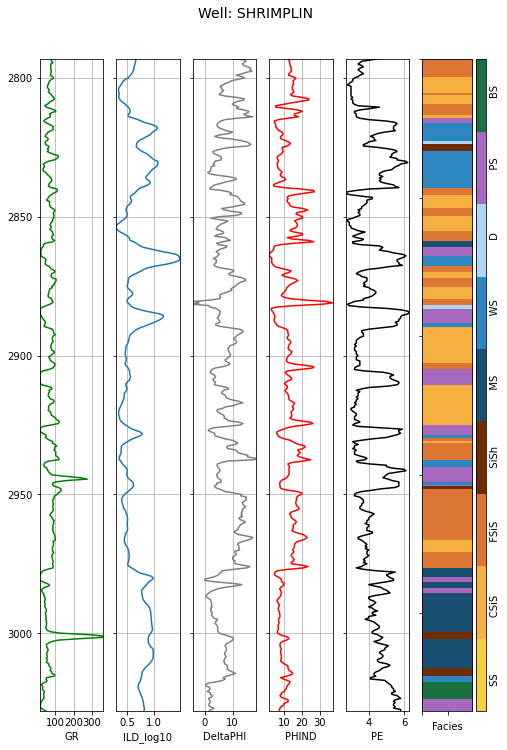

In [ ]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histgram of the number of training examples for each facies class.

SS      259
CSiS    738
FSiS    615
SiSh    184
MS      217
WS      462
D        98
PS      498
BS      161
Name: Facies, dtype: int64

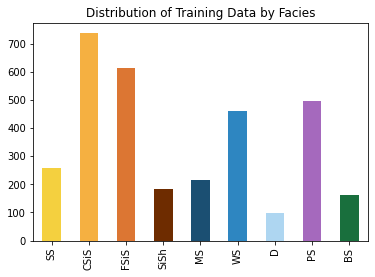

In [ ]:
#count the number of unique entries for each facies, sort them by facies number (instead of by number of entries)
#计算每个相的唯一条目数，然后按相数（而不是条目数）对它们进行排序
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
#使用相标签索引每个计数
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

This shows the distribution of examples by facies for the 3232 training examples in the training set.  Dolomite (facies 7) has the fewest with 141 examples.  There are also only 185 bafflestone examples.  Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

这显示了训练集中3232个训练实例的相分布。白云岩(相7)最少，有141个实例。也只有185个莫名其妙的例子。根据我们要训练的分类器的性能，我们可以考虑获得更多的这些相的例子。



Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type.  This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset.  We can employ the very useful [Seaborn library](https://stanford.edu/~mwaskom/software/seaborn/) to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies.  The same colormap is used to represent the 9 facies.  

交会图是地球科学中常见的一种工具，它可以直观地描述两种属性随岩石类型的变化。该数据集包含5个日志变量，散点矩阵可以帮助快速可视化数据集中所有变量之间的变化。我们可以使用非常有用的Seaborn库来快速创建一个漂亮的分散矩阵。图中的每个窗格显示x轴和y轴上的两个变量之间的关系，每个点根据其相进行着色。相同的颜色图用于表示9相。

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/

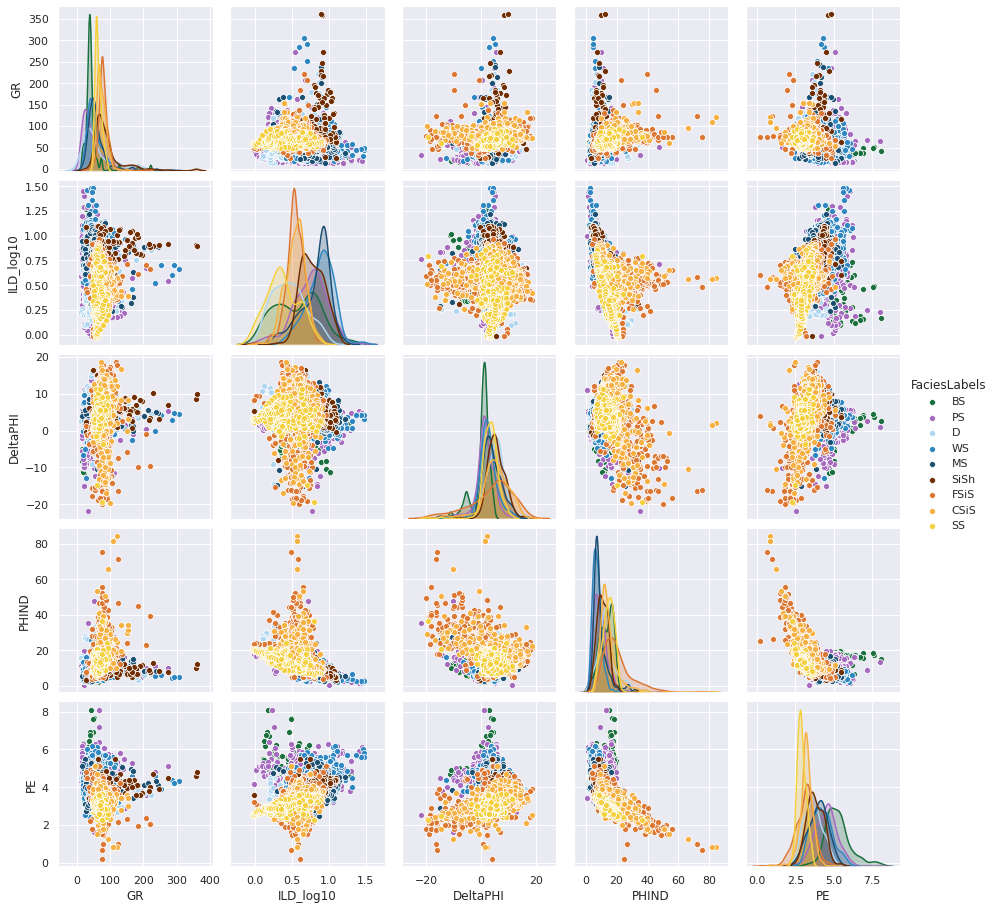

In [ ]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)


现在，我们仅提取执行分类所需的特征变量。 预测变量是五个有线值和两个地质约束变量。 我们还获得了与每个特征向量相对应的相标签向量。

In [ ]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000



Scikit包含一个预处理模块，可以“标准化”数据（赋予每个变量零均值和单位方差，也称为白化）。 许多机器学习算法都假定特征将是标准的正态分布数据（即：均值和单位方差为零的高斯）。 用于标准化训练集的因素必须应用于将输入到分类器的任何后续功能集中。 StandardScalar类可以适合于训练集，并在以后用于标准化任何训练数据。

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [ ]:
feature_vectors

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,78.260,0.661,14.200,12.565,4.100,1,0.979
2,79.050,0.658,14.800,13.050,3.600,1,0.957
3,86.100,0.655,13.900,13.115,3.500,1,0.936
4,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...
3227,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,51.469,0.965,3.083,7.708,3.152,2,0.661


Scikit also includes a handy function to randomly split the training data into training and test sets.  The test set contains a small subset of feature vectors that are not used to train the network.  Because we know the true facies labels for these examples, we can compare the results of the classifier to the actual facies and determine the accuracy of the model.  Let's use 20% of the data for the test set.

Scikit还包括方便的功能，可将训练数据随机分为训练和测试集。 测试集包含一小部分特征向量，这些特征向量不用于训练网络。 因为我们知道这些示例的真实相标签，所以我们可以将分类器的结果与实际相进行比较，并确定模型的准确性。 让我们将20％的数据用于测试集。

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Machine-Learning-From-Scratch-master')

#使用GBDT


In [ ]:
##使用pca后的GBDT
max_depth=4
max_features=10
n_estimators=80
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics
gbm0= GradientBoostingClassifier(random_state=10)
gbm0.fit(X_trains,y_train)
y_pred= gbm0.predict(X_tests)
print("Accuracy : %.4f" % sklearn.metrics.accuracy_score(y_test, y_pred))


Accuracy : 0.4250


In [ ]:
max_depth=4
max_features=10
n_estimators=80
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics
gbm0= GradientBoostingClassifier(random_state=10)
gbm0.fit(X_train,y_train)
y_pred= gbm0.predict(X_test)
print("Accuracy : %.4f" % sklearn.metrics.accuracy_score(y_test, y_pred))

Accuracy : 0.6491


#KNN

Accuracy: 0.7017001545595054


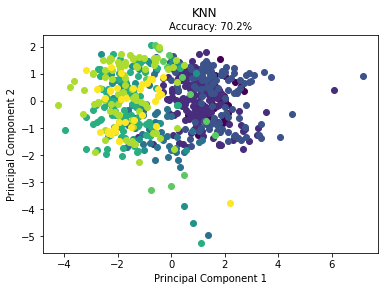

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

from utils import train_test_split, normalize, accuracy_score
from utils import euclidean_distance, Plot
class KNN():

    def __init__(self,k=5):

        self.k = k
    def predict(self, X_test, X_train, y_train):

        y_predict = np.zeros(X_test.shape[0])

        for i in range(X_test.shape[0]):

            distances = np.zeros((X_train.shape[0], 2)) #测试的数据和训练的各个数据的欧式距离

            for j in range(X_train.shape[0]):
                dis = euclidean_distance(X_test[i], X_train[j]) #计算欧式距离
                label = y_train[j] #测试集到的每个训练集的数据的分类标签
                distances[j] = [dis, label]

                # argsort()得到测试集到训练的各个数据的欧式距离从小到大排列并且得到序列，然后再取前k个.
                k_nearest_neighbors = distances[distances[:, 0].argsort()][:self.k]

                #利用np.bincount统计k个近邻里面各类别出现的次数
                counts = np.bincount(k_nearest_neighbors[:, 1].astype('int'))

                #得出每个测试数据k个近邻里面各类别出现的次数最多的类别
                testLabel = counts.argmax()
                y_predict[i] = testLabel

        return y_predict

def run():
    #初始化knn
    model = KNN(k=5)
    y_pred = model.predict(X_test, X_train, y_train)

    accuracy = accuracy_score(y_test, y_pred)

    print("Accuracy:", accuracy)

    # 用图画出测试集的分类情况
    Plot().plot_in_2d(X_test, y_pred, title="KNN", accuracy=accuracy)


if __name__ == "__main__":
    run()

#使用随机森林

In [ ]:
import sys
sys.path.append('/content/Machine-Learning-From-Scratch')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rfmodel = RandomForestClassifier()
rfmodel.fit(X_train,y_train)
print('model')
print(rfmodel)

ypredrf1 = rfmodel.predict(X_test)
print('confusion matrix')
print(metrics.confusion_matrix(y_test, ypredrf1))
print('classification report')
print(metrics.classification_report(y_test, ypredrf1))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, ypredrf1)))

model
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
confusion matrix
[[ 33  10   3   0   0   0   0   0   0]
 [  4 121  27   0   0   0   1   0   0]
 [  0  30  94   0   0   1   0   1   0]
 [  0   0   2  22   1   2   0   1   0]
 [  0   1   1   5  22  10   0   8   0]
 [  0   0   0   6   1  76   1  15   1]
 [  0   0   0   1   0   0  13   7   1]
 [  0   0   2   4   2  13   3  69   1]
 [  0   0   0   0   0   0   0   2  29]]
classification report
              precision    recall  f1-score   support

 

In [ ]:
#使用pca后的随机森林
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rfmodel = RandomForestClassifier()
rfmodel.fit(X_trains,y_train)
print('model')
print(rfmodel)

ypredrf1 = rfmodel.predict(X_tests)
print('confusion matrix')
print(metrics.confusion_matrix(y_test, ypredrf1))
print('classification report')
print(metrics.classification_report(y_test, ypredrf1))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, ypredrf1)))

model
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
confusion matrix
[[27 12  4  2  0  0  1  0  0]
 [48 64 30  0  3  2  2  4  0]
 [22 31 58  1  4  0  3  7  0]
 [ 0  5  5 10  1  4  0  3  0]
 [ 1  3  2  4 11 12  1 13  0]
 [ 0  3  2 12  6 40  2 34  1]
 [ 0  3  4  1  0  4  1  3  6]
 [ 0  7  3  9  5 19  2 48  1]
 [ 0  0  0  0  3 12  0 13  3]]
classification report
              precision    recall  f1-score   support

           1       0.28      0.59      0.38        46
           2       0.50     

#采用SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
sm = SMOTE(random_state=123)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

train_x = pd.DataFrame(X_train_sm)
train_y = pd.DataFrame(y_train_sm)
print(Counter(y_train_sm))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

Counter({5: 585, 2: 585, 9: 585, 3: 585, 8: 585, 1: 585, 6: 585, 4: 585, 7: 585})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#采用smote的随机森林

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rfmodel = RandomForestClassifier()
rfmodel.fit(train_x,train_y)
print('model')
print(rfmodel)

ypredrf1 = rfmodel.predict(X_test)
print('confusion matrix')
print(metrics.confusion_matrix(y_test, ypredrf1))
print('classification report')
print(metrics.classification_report(y_test, ypredrf1))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, ypredrf1)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


model
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
confusion matrix
[[ 37   8   1   0   0   0   0   0   0]
 [  8 118  26   0   0   1   0   0   0]
 [  2  25  96   0   0   2   0   1   0]
 [  0   0   1  24   1   1   0   1   0]
 [  0   1   1   4  28   6   1   6   0]
 [  0   0   0  11   5  67   2  13   2]
 [  0   0   0   1   1   0  11   7   2]
 [  0   0   1   6   4  13   3  66   1]
 [  0   0   0   0   0   0   0   0  31]]
classification report
              precision    recall  f1-score   support

 

#高斯混合模型

In [ ]:
!git clone https://github.com/1092798448/EM-GMM.git

Cloning into 'EM-GMM'...
remote: Enumerating objects: 9, done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 9
Unpacking objects: 100% (9/9), done.


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Machine-Learning-From-Scratch-master')

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=9, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
confusion matrix
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  2  0 38  0  0]
 [ 0 63  1  0  1 38  1 49  0  0]
 [ 0 43  1  0  0 66  3 12  1  0]
 [ 3  0  7  6  0  1  0  1 10  0]
 [22  1  7  1  0  1  2  1 12  0]
 [30  0 17 12  0  0  8  0 33  0]
 [ 3  0 14  3  0  0  2  0  0  0]
 [12  0 23 16  0  1 30  0 12  0]
 [ 1  0  0  2  0  0 28  0  0  0]]
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.05      0.13      0.08        46
           2       0.01      0.01      0.01       153
           3       0.00      0.00      0.00       126
           4       0.00      0.00      0.00        28


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


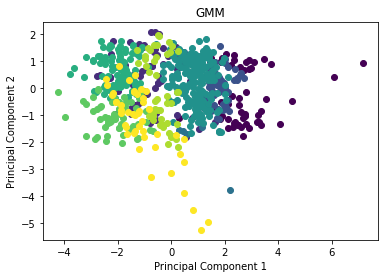

In [ ]:
from utils import train_test_split, normalize, accuracy_score
from utils import euclidean_distance, Plot
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=9)
gmm.fit(X_train)
ypredrf1 = gmm.predict(X_test)
print(gmm)
print('confusion matrix')
print(metrics.confusion_matrix(y_test, ypredrf1))
print('classification report')
print(metrics.classification_report(y_test, ypredrf1))
accuracy = accuracy_score(y_test, y_pred)
print(f'accuracy:{accuracy}')
Plot().plot_in_2d(X_test, y_pred, title="GMM")

#xgboost

Accuracy: 71.25%


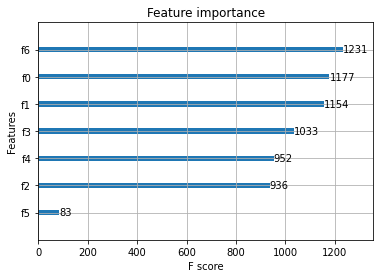

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot as plt

import xgboost as xgb
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

params ={'learning_rate': 0.4,
          'max_depth': 20,                # 构建树的深度，越大越容易过拟合
          'num_boost_round':2000,
          'objective': 'multi:softprob', # 多分类的问题
          'random_state': 7,
          'silent':0,
          'num_class':10,                 # 类别数，与 multisoftmax 并用
          'eta':0.8                      #为了防止过拟合，更新过程中用到的收缩步长。eta通过缩减特征 的权重使提升计算过程更加保守。缺省值为0.3，取值范围为：[0,1]
        }
model = xgb.train(params,xgb.DMatrix(X_train, y_train))
y_pred=model.predict(xgb.DMatrix(X_test))

model.save_model('testXGboostClass.model')  # 保存训练模型

yprob = np.argmax(y_pred, axis=1)  # return the index of the biggest pro

predictions = [round(value) for value in yprob]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 显示重要特征
plot_importance(model)
plt.show()

#使用smote的xgboost

Accuracy: 73.42%


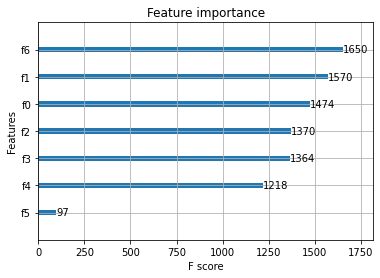

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot as plt

import xgboost as xgb
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

params ={'learning_rate': 0.4,
          'max_depth': 20,                # 构建树的深度，越大越容易过拟合
          'num_boost_round':2000,
          'objective': 'multi:softprob', # 多分类的问题
          'random_state': 7,
          'silent':0,
          'num_class':10,                 # 类别数，与 multisoftmax 并用
          'eta':0.8                      #为了防止过拟合，更新过程中用到的收缩步长。eta通过缩减特征 的权重使提升计算过程更加保守。缺省值为0.3，取值范围为：[0,1]
        }
model = xgb.train(params,xgb.DMatrix(X_train_sm, y_train_sm))
y_pred=model.predict(xgb.DMatrix(X_test))

model.save_model('testXGboostClass.model')  # 保存训练模型

yprob = np.argmax(y_pred, axis=1)  # return the index of the biggest pro

predictions = [round(value) for value in yprob]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 显示重要特征
plot_importance(model)
plt.show()